
El objetivo de esta notebook es realizar un análisis y predicción sobre fraude bancario. Lo que consiste tanto uso de pipes para organizar los pasos y evitar problemas como el uso de algorítmos de balanceo de datos.



# Carga de datos


In [ ]:
#------------Montar el Drive y acceder a la API con la key -------------

import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/Data Proyects/kaggle.json", 'r') as f:   #Aca tenes que descargarte tu "key" de Kaggle y ponerla en una carpeta en Drive, y poner el nombre en tu carpeta.
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d mlg-ulb/creditcardfraud

 76% 50.0M/66.0M [00:00<00:00, 183MB/s]
100% 66.0M/66.0M [00:00<00:00, 186MB/s]


In [ ]:
import zipfile

import os



os.listdir()



for file in os.listdir():

    if file.endswith('.zip'):

      zip_ref = zipfile.ZipFile(file, 'r')

      zip_ref.extractall()

      zip_ref.close()

In [2]:
import pickle
from tempfile import mkdtemp
from shutil import rmtree

%pip install feature_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from feature_engine.preprocessing import MatchVariables
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.imputation import (
    AddMissingIndicator, MeanMedianImputer, CategoricalImputer, EndTailImputer
)
from feature_engine.transformation import PowerTransformer
from feature_engine.creation import RelativeFeatures
from feature_engine.selection import DropFeatures

In [3]:
df = pd.read_csv('creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# EDA

In [4]:
df.shape

(284807, 31)

Tiene 284807 registros y 31 variables

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


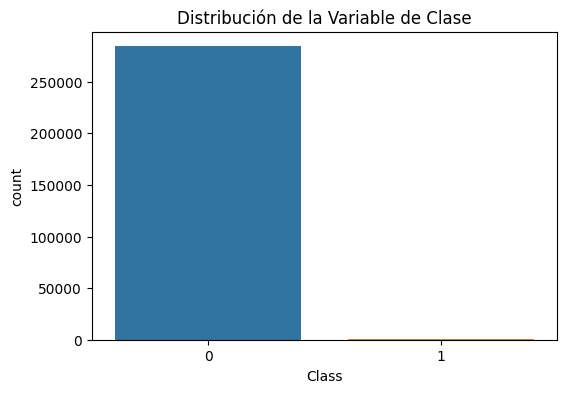

In [5]:
import seaborn as sns

# Visualización de la variable 'class'
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Distribución de la Variable de Clase')
plt.show()

<ipython-input-16-b9705670b0c7>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(amount_val, ax=ax[0], color='r')
<ipython-input-16-b9705670b0c7>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(time_val, ax=ax[1], color='b')


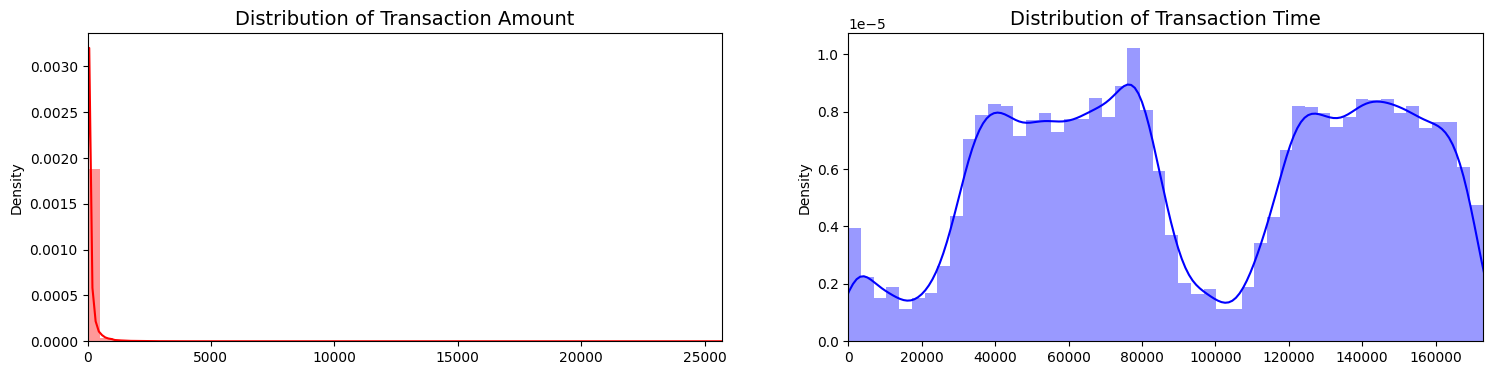

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

## Escalado de los datos para que todo este escalado

In [6]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

## Aplico SMOTE Y NM

Es mejor hacerlo antes de dividir o aplicar SMOTE sobre el conjunto ya dividido??


In [ ]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Suponiendo que ya tienes tu DataFrame cargado como df

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Aplicar Near Miss para under-sampling
nm = NearMiss()
X_under, y_under = nm.fit_resample(X, y)

# Aplicar SMOTE para over-sampling
smote = SMOTE()
X_over, y_over = smote.fit_resample(X, y)

# Puedes imprimir las formas de los nuevos conjuntos de datos para verificar el cambio en el tamaño
print("Shape of under-sampled data:", X_under.shape, y_under.shape)
print("Shape of over-sampled data:", X_over.shape, y_over.shape)

# También puedes dividir los conjuntos de datos en entrenamiento y prueba si lo deseas
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)


Shape of under-sampled data: (984, 30) (984,)
Shape of over-sampled data: (568630, 30) (568630,)


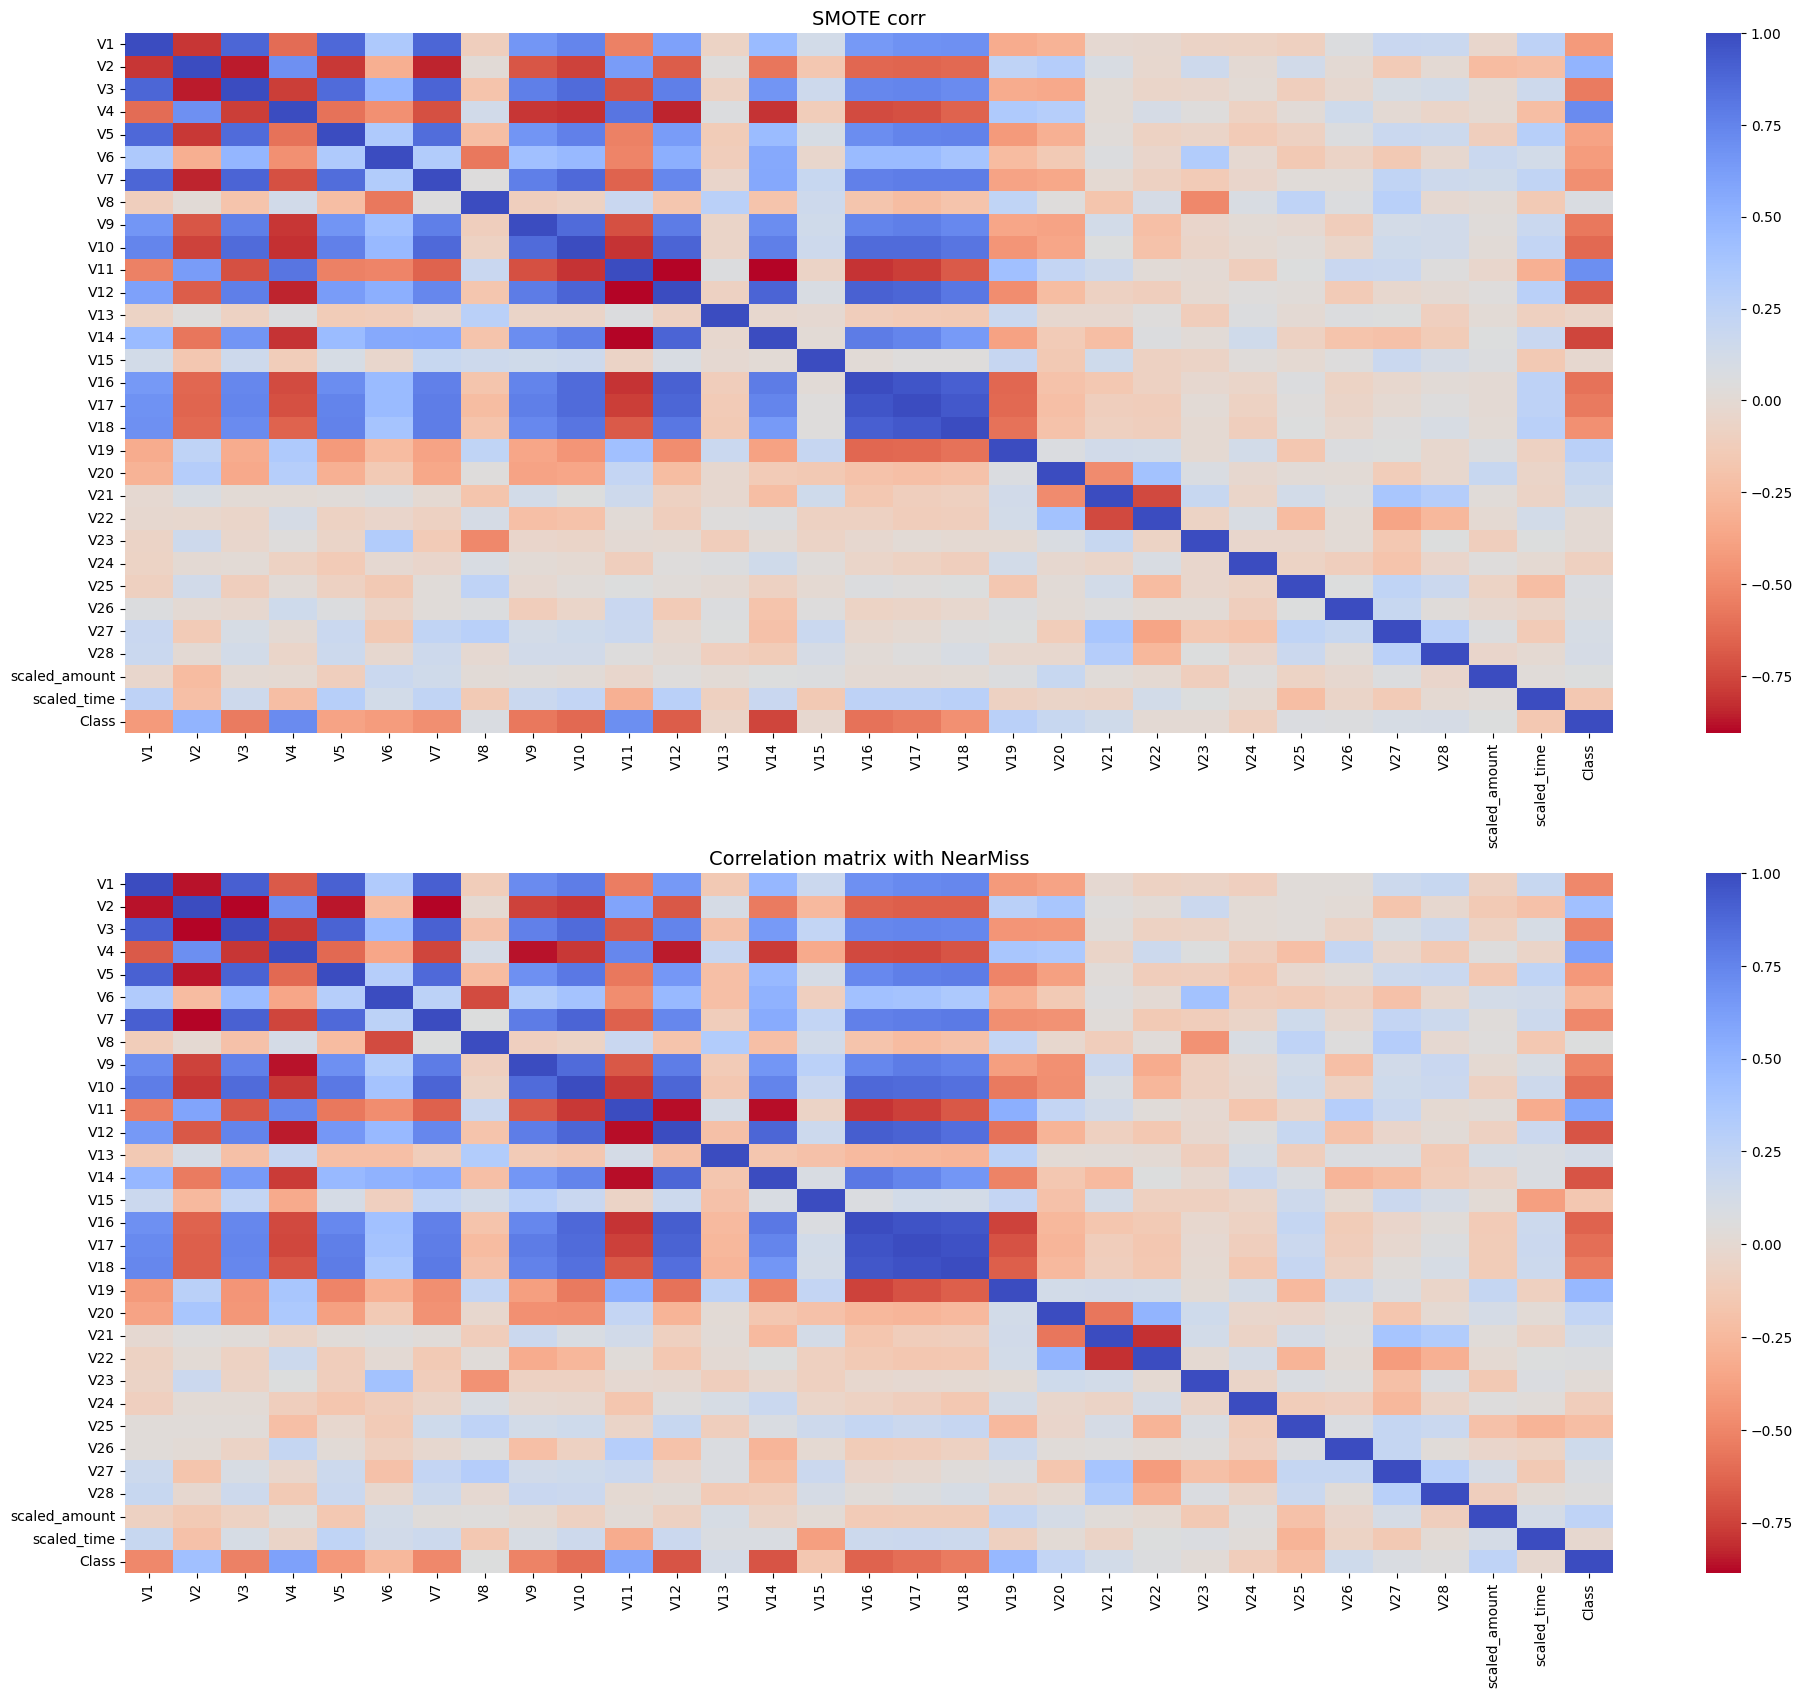

<Figure size 1200x1000 with 0 Axes>

In [ ]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame

df_combined_over = pd.concat([X_over, y_over], axis=1)

# Calcular la matriz de correlación
corr_matrix_over = df_combined_over.corr()
sns.heatmap(corr_matrix_over, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("SMOTE corr", fontsize=14)

df_combined_under = pd.concat([X_under, y_under], axis=1)

# Calcular la matriz de correlación
corr_matrix_under = df_combined_under.corr()

# Crear un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_under, cmap='coolwarm_r', annot_kws={'size':20},ax = ax2)
ax2.set_title('Correlation matrix with NearMiss', fontsize=14)
plt.show()

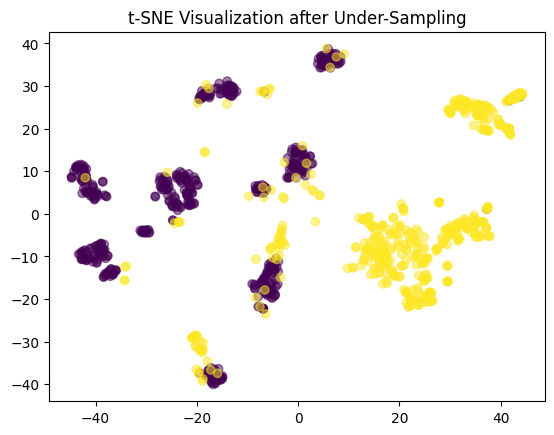

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Suponiendo que X_under o X_over es tu conjunto de datos después del preprocesamiento
X_tsne = tsne.fit_transform(X_under)  # O X_over, según tu elección

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_under, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization after Under-Sampling')
plt.show()


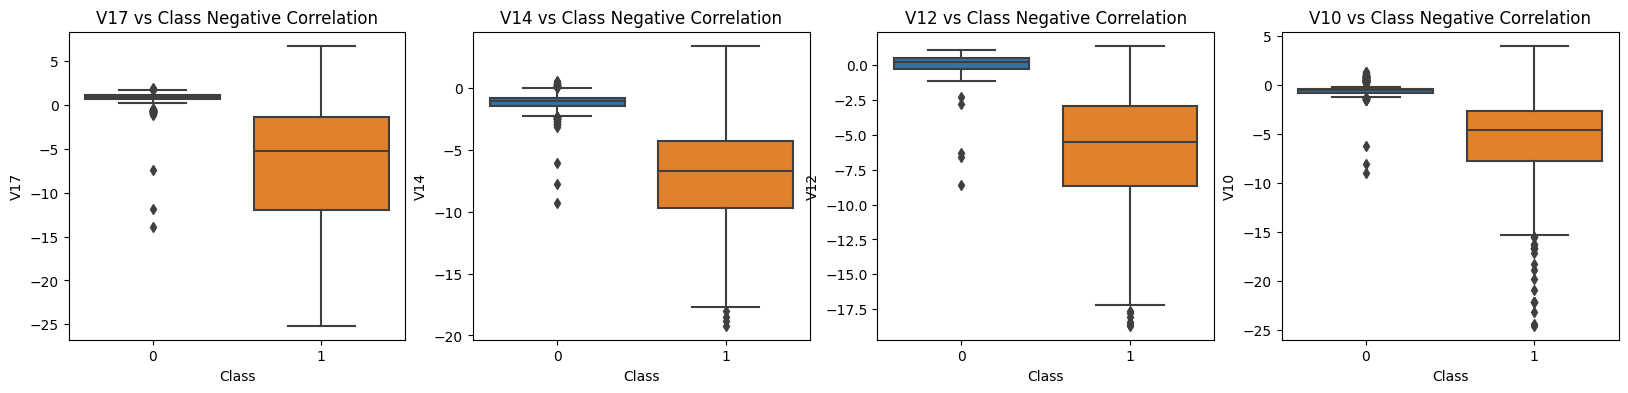

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=df_combined_under, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=df_combined_under, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=df_combined_under, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=df_combined_under, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

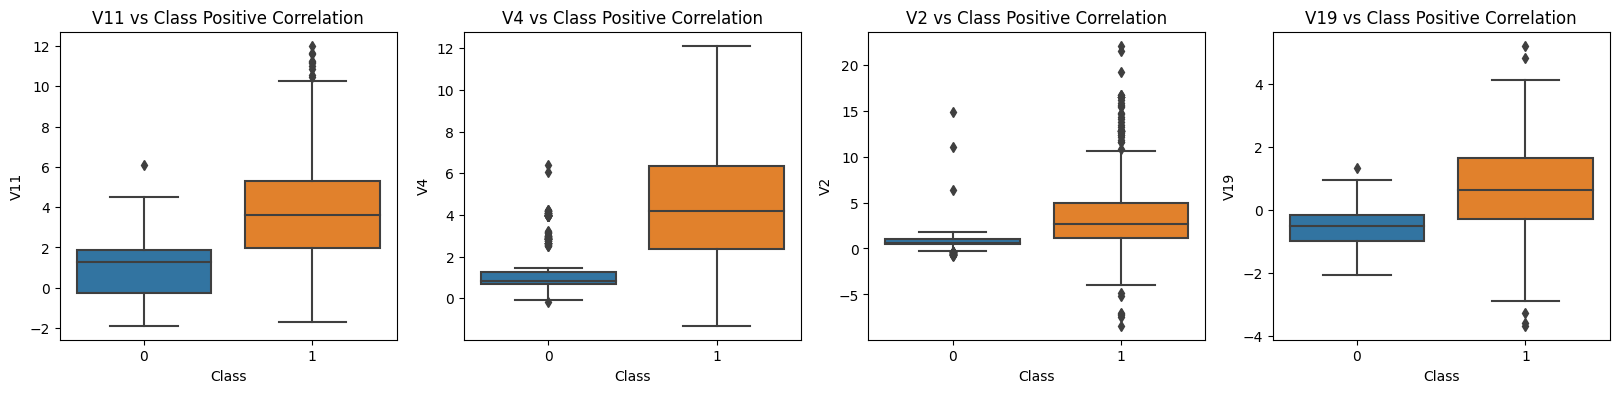

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=df_combined_under, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=df_combined_under, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=df_combined_under, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=df_combined_under, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

<ipython-input-36-d47164644416>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
<ipython-input-36-d47164644416>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
<ipython-input-36-d47164644416>:1

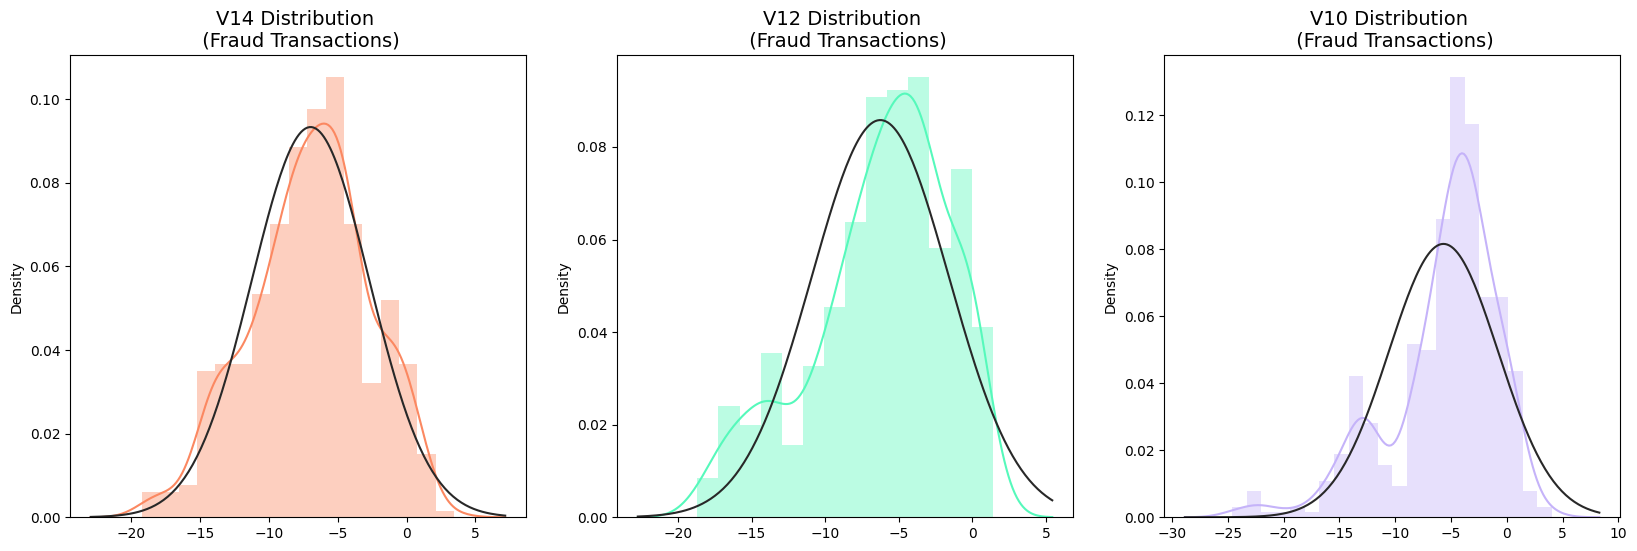

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = df_combined_under['V14'].loc[df_combined_under['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = df_combined_under['V12'].loc[df_combined_under['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = df_combined_under['V10'].loc[df_combined_under['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

## Saco Outliers en las variables mas importantes

In [ ]:
new_df = df_combined_under


# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.8220867423816, -18.4937733551053, -18.0499976898594]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.0475965708216, -18.6837146333443, -18.5536970096458, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-15.1241628144947, -16.649628

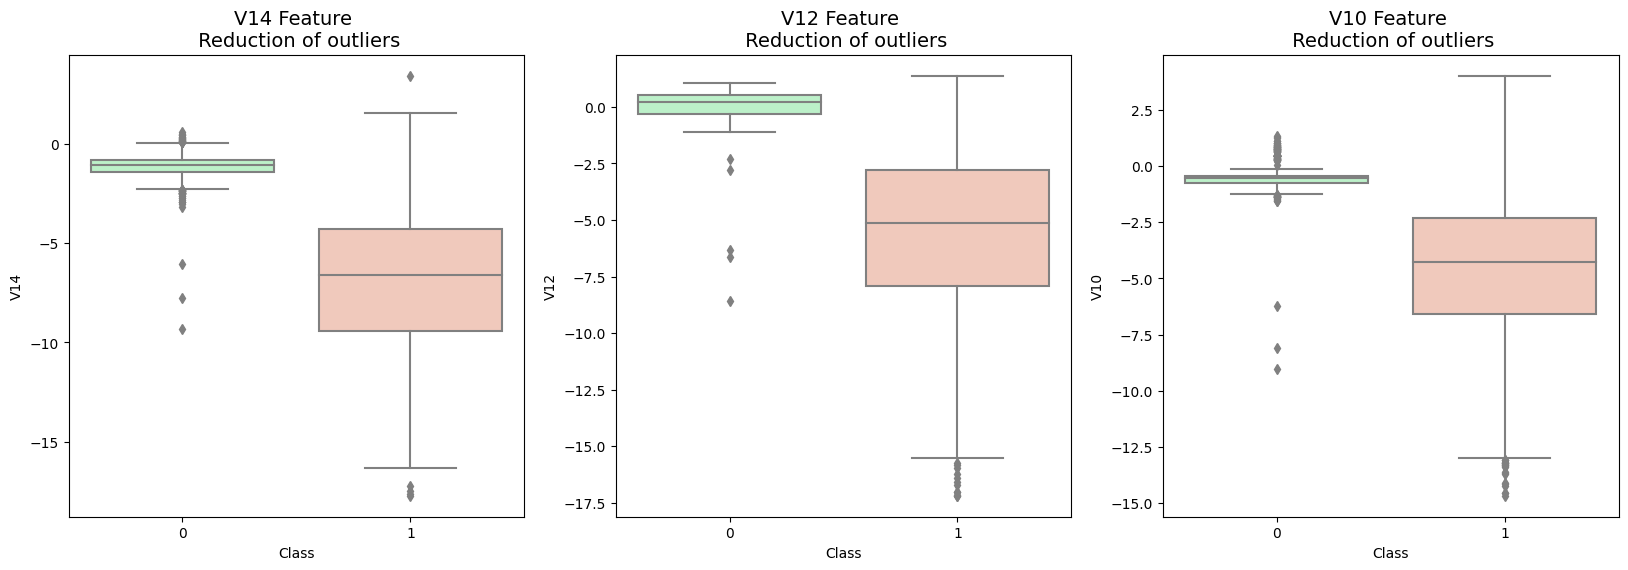

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)


# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)


# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)



plt.show()

# Models

## Logistic Regression Opt

Creo una regresión logísitca y la optimizo con un GridSearch, donde pruebo varias opciones de parámetros y métodos de balanceo. Importante aclarar que todo es hecho dentro de un pipe para evitar posibles data leakeages al conjunto de testo.

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score

# Suponiendo que X, y son tus características y etiquetas respectivamente
X = df.drop('Class', axis=1)
y = df['Class']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

folds = StratifiedKFold(n_splits=5)


# Definir el pipeline directamente con los pasos deseados
pipeline = Pipeline([
    ('sampling', NearMiss()),  # Puedes cambiarlo por SMOTE u otra técnica de balanceo
    ('classifier', LogisticRegression())  # Puedes cambiarlo por otro clasificador
])

# Definir los parámetros a ajustar en el GridSearch
parameters = {
    'sampling': [NearMiss(), SMOTE(),RandomUnderSampler(), RandomOverSampler()],  # Puedes agregar más técnicas de balanceo
    'classifier__C': [0.001, 0.1, 1, 10, 100],
    "classifier__penalty": ['l1', 'l2'],
    }


# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=folds, scoring='roc_auc', verbose=1)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

# Mostrar los mejores parámetros encontrados por GridSearch
print("Best Parameters:", grid_search.best_params_)


Accuracy: 0.9986306660580738
Precision: 0.5694444444444444
Recall: 0.8367346938775511
F1 Score: 0.6776859504132232


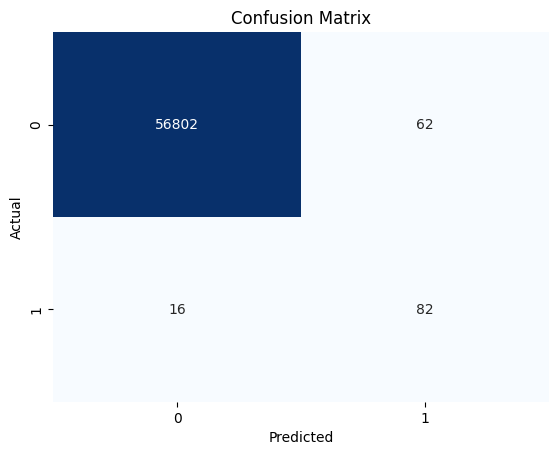

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns



# Calcular y mostrar métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
#Podemos ver todas las combinaciones de hiperparámetros más métodos de balanceo que usó

lista_params=grid_search.cv_results_['params']

for i,el in enumerate(lista_params):
    lista_params[i]['ranking']=grid_search.cv_results_['rank_test_score'][i]
    lista_params[i]['mean_score']=grid_search.cv_results_['mean_test_score'][i]
sorted(lista_params, key=lambda d: d['ranking'])

In [ ]:
pipe = Pipeline(steps = [('sampling',SMOTE()),('classifier',LogisticRegression())])

params = parameters = {
    'classifier__C': [0.001, 0.1, 1, 10, 100],
    "classifier__penalty": ['l1', 'l2'],
    }

grid2 = GridSearchCV(pipe, params, cv=folds, scoring='roc_auc', verbose=1)

In [ ]:
grid2.fit(X_train, y_train)

In [ ]:
grid2.best_params_

In [ ]:
#Podemos ver todas las combinaciones de hiperparámetros más métodos de balanceo que usó

lista_params=grid2.cv_results_['params']

for i,el in enumerate(lista_params):
    lista_params[i]['ranking']=grid2.cv_results_['rank_test_score'][i]
    lista_params[i]['mean_score']=grid2.cv_results_['mean_test_score'][i]
sorted(lista_params, key=lambda d: d['ranking'])

## XGBoost Opt

Luego de entrenar una regresion logísitca, veo el rendimiento de un algormitmo diferente desde el core como es este tipo de ADD + inteligente. Además por la cantidad de hiperparametros optimizo el pipe con una busqueda bayesiana que es más rapida (tardo 26' de todos modos)

In [10]:
%pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.2 MB/s eta 0:00:00


In [13]:
from imblearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import roc_auc_score

# Suponiendo que X, y son tus características y etiquetas respectivamente
X = df.drop('Class', axis=1)
y = df['Class']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

folds = StratifiedKFold(n_splits=5)

# Definir el pipeline directamente con los pasos deseados
pipeline = Pipeline([
    ('sampling', NearMiss()),  # Puedes cambiarlo por SMOTE u otra técnica de balanceo
    ('classifier', XGBClassifier())  # Cambiado a XGBClassifier
])

# Definir los parámetros a ajustar en el GridSearch
param_space = {
    'sampling': Categorical([NearMiss(), SMOTE(), RandomUnderSampler(), RandomOverSampler()]),  # Puedes agregar más técnicas de balanceo
    'classifier__n_estimators': Integer(50, 200),
    'classifier__learning_rate': Real(0.01, 0.2),
    'classifier__max_depth': Integer(3, 7),
    'classifier__min_child_weight': Integer(1, 5)
}

# Crear el objeto BayesSearchCV con scoring='roc_auc'
bayes_search_xgb = BayesSearchCV(pipeline, param_space, cv=folds, n_iter=50, scoring='roc_auc', n_jobs=-1, verbose=1)

# Ajustar el modelo
bayes_search_xgb.fit(X_train, y_train)

# Obtener el mejor modelo de XGBoost
xgb_best_model = bayes_search_xgb.best_estimator_

# Predecir en el conjunto de prueba
y_pred = xgb_best_model.predict(X_test)

# Calcular la métrica AUC-ROC del modelo
roc_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC on Test Set:", roc_auc)

# Mostrar los mejores parámetros encontrados por BayesSearchCV
print("Best Parameters:", bayes_search_xgb.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
AUC-ROC on Test Set: 0.9410835591974551
Best Parameters: OrderedDict([('classifier__learning_rate', 0.01), ('classifier__max_depth', 3), ('classifier__min_child_weight', 1), ('classifier__n_estimators', 200), ('sampling', SMOTE())])


Accuracy: 0.9840595484709105
Precision: 0.08924949290060852
Recall: 0.8979591836734694
F1 Score: 0.16236162361623616


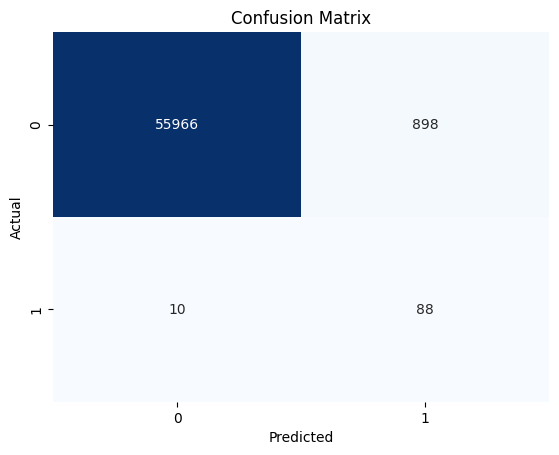

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns



# Calcular y mostrar métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Testeo el mejor XGB con datos balanceados de testeo, aunque es importante el train y test anteriror. Puede que las metricas esten sesgadas por el desbalanceo de clases. Por eso hago un balanceo solo al conjunto de test.

In [17]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.metrics import classification_report

# Suponiendo que X_test y y_test son tus características y etiquetas en el conjunto de prueba

# Aplicar el mismo muestreo que se utilizó en el conjunto de entrenamiento
#rus = RandomUnderSampler(random_state=42)
nm = NearMiss()
X_test_resampled, y_test_resampled = nm.fit_resample(X_test, y_test)

# Utilizar el mejor modelo para predecir en el conjunto de prueba resampleado
y_pred_test = xgb_best_model.predict(X_test_resampled)

# Calcular y mostrar métricas en el conjunto de prueba resampleado
roc_auc_test = roc_auc_score(y_test_resampled, y_pred_test)
print("AUC-ROC on Resampled Test Set:", roc_auc_test)

# Puedes mostrar otras métricas como precisión, recall, F1-score, etc.
print(classification_report(y_test_resampled, y_pred_test))


AUC-ROC on Resampled Test Set: 0.836734693877551
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        98
           1       0.80      0.90      0.85        98

    accuracy                           0.84       196
   macro avg       0.84      0.84      0.84       196
weighted avg       0.84      0.84      0.84       196



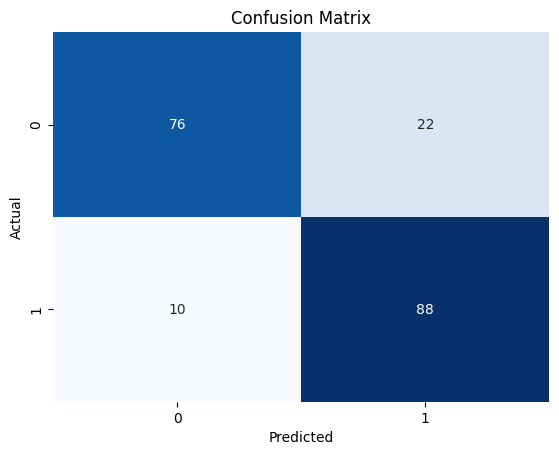

In [18]:

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_resampled, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Ahora quiero probar lo mismo pero con la regresion logistica que entrene antes.

In [24]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.metrics import classification_report

# Suponiendo que X_test y y_test son tus características y etiquetas en el conjunto de prueba

# Aplicar el mismo muestreo que se utilizó en el conjunto de entrenamiento
#rus = RandomUnderSampler(random_state=42)
nm = NearMiss()
X_test_resampled, y_test_resampled = nm.fit_resample(X_test, y_test)

# Utilizar el mejor modelo para predecir en el conjunto de prueba resampleado
y_pred_test = best_model.predict(X_test_resampled)

# Calcular y mostrar métricas en el conjunto de prueba resampleado
roc_auc_test = roc_auc_score(y_test_resampled, y_pred_test)
print("AUC-ROC on Resampled Test Set:", roc_auc_test)

# Puedes mostrar otras métricas como precisión, recall, F1-score, etc.
print(classification_report(y_test_resampled, y_pred_test))

AUC-ROC on Resampled Test Set: 0.9183673469387755
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        98
           1       1.00      0.84      0.91        98

    accuracy                           0.92       196
   macro avg       0.93      0.92      0.92       196
weighted avg       0.93      0.92      0.92       196



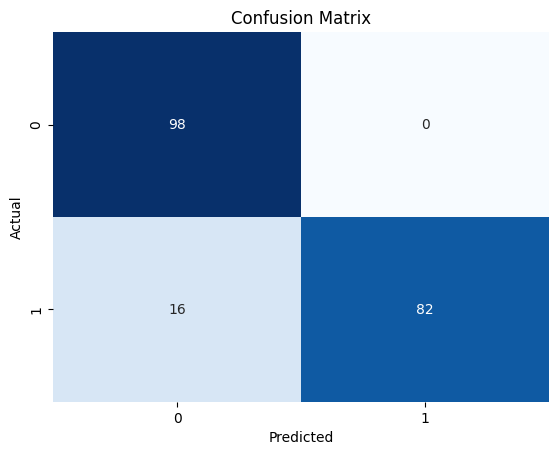

In [25]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_resampled, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()